## Dataset and Problem Introduction

This notebook walks through loading and processing images that allow for building models that can detect images of honeybees and bumblebees.

Data Source: https://beespotter.org/
<br>Reference: https://www.datacamp.com/

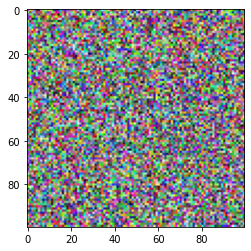

In [1]:
# Used to change filepaths
from pathlib import Path

# We set up matplotlib, pandas, and the display function
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
import pandas as pd

# import numpy to use in this cell
import numpy as np

# import Image from PIL so we can use it later
from PIL import Image

# generate test_data
test_data = np.random.beta(1, 1, size=(100, 100, 3))

# display the test_data
plt.imshow(test_data)

## Opening images with Pillow

<p>Pillow is a very flexible image loading and manipulation library. It works with many different image formats, for example, <code>.png</code>, <code>.jpg</code>, <code>.gif</code> and more.
<p>In this notebook we want to load an image, display it, and print out the dimensions (width and the height of the image in pixels). The documentation for <a href="https://pillow.readthedocs.io/en/5.1.x/reference/Image.html">Image</a> in Pillow gives a comprehensive view of what this object can do.</p>

The image size is: (100, 100)


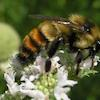

In [2]:
# open the image
img = Image.open('datasets/bee_1.jpg')

# Get the image size
img_size = img.size

print("The image size is: {}".format(img_size))

# Just having the image as the last line in the cell will display it in the notebook
img

## Image manipulation with Pillow
<p>Pillow has a number of common image manipulation tasks built into the library. Operations that Pillow provides include:</p>
<ul>
<li>resizing</li>
<li>cropping</li>
<li>rotating</li>
<li>flipping</li>
<li>converting to greyscale (or other <a href="https://pillow.readthedocs.io/en/5.1.x/handbook/concepts.html#concept-modes">color modes</a>)</li>
</ul>
<p>Often, these kinds of manipulations are part of a pipeline for turning a small number of images into more images to create training data for machine learning algorithms. This technique is called <a href="http://cs231n.stanford.edu/reports/2017/pdfs/300.pdf">data augmentation</a>, and is a common technique for image classification.</p>

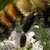

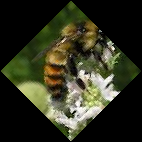

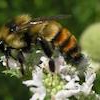

In [3]:
# Crop the image to 25, 25, 75, 75
img_cropped = img.crop([25, 25, 75, 75])
display(img_cropped)

# rotate the image by 45 degrees
img_rotated = img.rotate(45, expand=25)
display(img_rotated)

# flip the image left to right
img_flipped = img.transpose(Image.FLIP_LEFT_RIGHT)
display(img_flipped)

## Images as arrays of data
<p>Most image formats have three colour "channels": <a href="https://en.wikipedia.org/wiki/RGB_color_model">red, green, and blue</a> (some images also have a fourth channel called "alpha" that controls transparency). For each pixel in an image, there is a value for every channel.</p>
<p>In the data, this is represented as a three-dimensional matrix. The width of the matrix is the width of the image, the height of the matrix is the height of the image, and the depth of the matrix is the number of channels.</p>

Our NumPy array has the shape: (100, 100, 3)


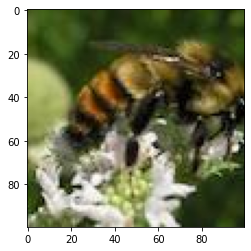

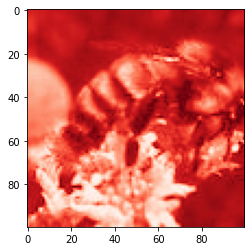

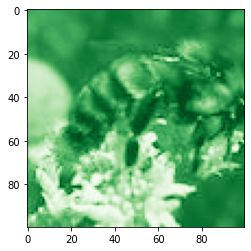

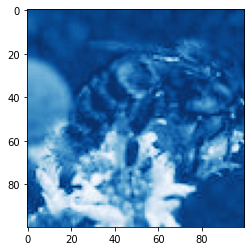

In [4]:
# Turn our image object into a NumPy array
img_data = np.array(img)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow`
plt.imshow(img_data)
plt.show()

# plot the red channel
plt.imshow(img_data[:, :, 0], cmap=plt.cm.Reds_r)
plt.show()

# plot the green channel
plt.imshow(img_data[:, :, 1], cmap=plt.cm.Greens_r)
plt.show()

# plot the blue channel
plt.imshow(img_data[:, :, 2], cmap=plt.cm.Blues_r)
plt.show()

## Colour channels
<p>Color channels can help provide more information about an image. A picture of the ocean will be more blue, whereas a picture of a field will be more green. This kind of information can be useful when building models or examining the differences between images.</p>
<p>We look at the <a href="https://en.wikipedia.org/wiki/Kernel_density_estimation">kernel density estimate</a> for each of the colour channels on the same plot so that we can understand how they differ.</p>

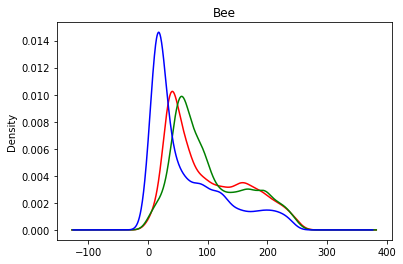

In [5]:
def plot_kde(channel, color):
    """ Plots a kernel density estimate for the given data.
        
        `channel` must be a 2d array
        `color` must be a color string, e.g. 'r', 'g', or 'b'
    """
    data = channel.flatten()
    return pd.Series(data).plot.density(c=color)

# create the list of channels
channels = ['r', 'g', 'b']
    
def plot_rgb(image_data, title):
    # use enumerate to loop over colors and indexes
    for ix, color in enumerate(channels):
        kk = plot_kde(image_data[:, :, ix], color)
        
    kk.set_title(title)
    plt.show()

plot_rgb(img_data, "Bee")

We see that a shape that appears further to the right means more of that color, whereas further to the left means less of that color.

## Honey bees and bumble bees
<p>Now we look at two different images and some of the differences between them. The first image is of a honey bee, and the second image is of a bumble bee.</p>

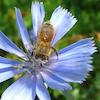

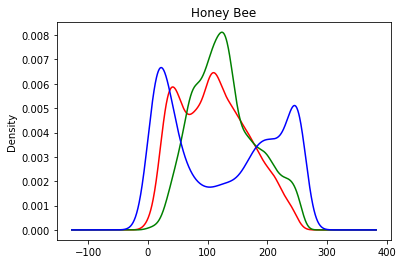

In [6]:
# load bee_12.jpg as honey
honey = Image.open('datasets/bee_2.jpg')

# display the honey bee image
display(honey)

# NumPy array of the honey bee image data
honey_data = np.array(honey)

# plot the rgb densities for the honey bee image
plot_rgb(honey_data, "Honey Bee")

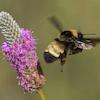

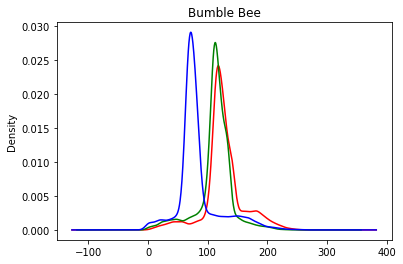

In [7]:
# load bee_3.jpg as bumble
bumble = Image.open('datasets/bee_3.jpg')

# display the bumble bee image
display(bumble)

# NumPy array of the bumble bee image data
bumble_data = np.array(bumble)

# plot the rgb densities for the bumble bee image
plot_rgb(bumble_data, "Bumble Bee")

<p>When one compares these images, it is clear how different the colors are. The honey bee image with a blue flower, has a strong peak on the right-hand side of the blue channel. The bumble bee image, which has a lot of yellow for the bee and the background, has almost perfect overlap between the red and green channels (which together make yellow).</p>

## Grayscale
<p>While colour information is useful, sometimes it can be distracting. In these examples the bees themselves are very similar colours. But on the other hand, the bees are often on top of different colour flowers, and the colours of the flowers may be distracting from separating honey bees from bumble bees. To handle this, we can convert these images to <a href="https://en.wikipedia.org/wiki/Grayscale">black-and-white, or "grayscale."</a></p>

<p>Grayscale is just one of the <a href="https://pillow.readthedocs.io/en/5.0.0/handbook/concepts.html#modes">modes that Pillow supports</a>. Switching between modes is done with the <code>.convert()</code> method, which is passed as a string for the new mode.</p>

<p>Because we change the number of colour "channels," the shape of our array changes. It is interesting to look at how the KDE of the grayscale version compares to the RGB version above.</p>

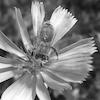

Our NumPy array has the shape: (100, 100)


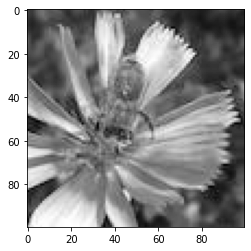

<AxesSubplot:ylabel='Density'>

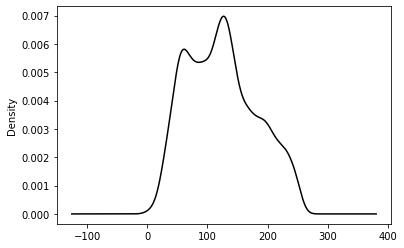

In [8]:
# convert to grayscale
honey_bw = honey.convert("L")
display(honey_bw)

# convert the image to a NumPy array
honey_bw_arr = np.array(honey_bw)

# get the shape of the resulting array
honey_bw_arr_shape = honey_bw_arr.shape
print("Our NumPy array has the shape: {}".format(honey_bw_arr_shape))

# plot the array using matplotlib
plt.imshow(honey_bw_arr, cmap=plt.cm.gray)
plt.show()

# plot the kde of the new black and white array
plot_kde(honey_bw_arr, 'k')

## Saving changes
<p>Now we make a couple changes to the <code>Image</code> object from Pillow and save the file.</p>

We first flip the image left-to-right, then change the NumPy version of the data by clipping it. Using the <code>np.maximum</code> function, we can take any number in the array smaller than <code>100</code> and replace it with <code>100</code>. Because this reduces the range of values, it will increase the <a href="https://en.wikipedia.org/wiki/Contrast_(vision)">contrast of the image</a>. Finally, we convert the object back to an <code>Image</code> and save the result.</p>

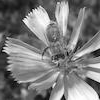

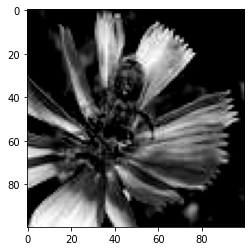

In [9]:
honey_bw_flip = honey_bw.transpose(Image.FLIP_LEFT_RIGHT)

# show the flipped image
display(honey_bw_flip)

# save the flipped image
honey_bw_flip.save("datasets/saved_images/bw_flipped.jpg")

# create higher contrast by reducing range
honey_hc_arr = np.maximum(honey_bw_arr, 100)

# show the higher contrast version
plt.imshow(honey_hc_arr, cmap=plt.cm.gray)

# convert the NumPy array of high contrast to an Image
honey_bw_hc = Image.fromarray(honey_hc_arr)

# save the high contrast version
honey_bw_hc.save("datasets/saved_images/bw_hc.jpg")

## Pipeline
<p>In this pipeline we do the following:</p>
<ul>
<li>Load an image with <code>Image.open</code> and create paths to save it</li>
<li>Convert the image to grayscale</li>
<li>Save the grayscale image</li>
<li>Rotate, crop, and zoom in on the image</li>
<li>Save the new image</li>
</ul>

In [10]:
image_paths = ['datasets/bee_1.jpg', 'datasets/bee_2.jpg', 'datasets/bee_3.jpg']

def process_image(path):
    img = Image.open(path)

    # create paths to save files to
    bw_path = "datasets/saved_images/bw_{}.jpg".format(path.stem)
    rcz_path = "datasets/saved_images/rcz_{}.jpg".format(path.stem)

    print("Creating grayscale version of {} and saving to {}.".format(path, bw_path))
    bw = img.convert('L')
    bw.save(bw_path)

    print("Creating rotated, cropped, and zoomed version of {} and saving to {}.".format(path, rcz_path))
    rcz = img.rotate(45).crop([25, 25, 75, 75]).resize((100, 100))
    rcz.save(rcz_path)

# for loop over image paths
for img_path in image_paths:
    process_image(Path(img_path))

Creating grayscale version of datasets\bee_1.jpg and saving to datasets/saved_images/bw_bee_1.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_1.jpg and saving to datasets/saved_images/rcz_bee_1.jpg.
Creating grayscale version of datasets\bee_2.jpg and saving to datasets/saved_images/bw_bee_2.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_2.jpg and saving to datasets/saved_images/rcz_bee_2.jpg.
Creating grayscale version of datasets\bee_3.jpg and saving to datasets/saved_images/bw_bee_3.jpg.
Creating rotated, cropped, and zoomed version of datasets\bee_3.jpg and saving to datasets/saved_images/rcz_bee_3.jpg.
